In [21]:
import torch
import matplotlib.pyplot as plt
from transformers import GLPNImageProcessor,GLPNForDepthEstimation
from PIL import Image

In [44]:
#Loading Pretrained Depth Estimation Model
feature_extractor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")
img = Image.open("C:/Users/Admin/Pictures/bird.jpg")

In [45]:
#Image Loading and Resizing
new_ht = 480 if img.height > 480 else img.height
new_ht -= (new_ht % 32)
new_wd = int(new_ht * img.width / img.height)
diff = new_wd % 32

new_wd = new_wd - diff if diff < 16 else new_wd + 32 - diff
new_size = (new_wd , new_ht)
img = img.resize(new_size)

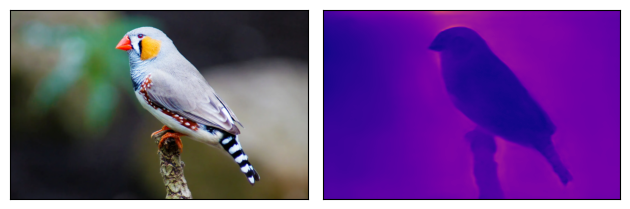

In [46]:
#Depth Prediction

inputs = feature_extractor(images = img,return_tensors ="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

pad=16
output = predicted_depth.squeeze().cpu().numpy()*1000.0
output = output[pad:-pad , pad:-pad]
img = img.crop((pad,pad,img.width - pad,img.height - pad))

fig,ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[0].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
ax[1].imshow(output,cmap='plasma')
ax[1].tick_params(left=False,bottom=False,labelleft=False,labelbottom = False)
plt.tight_layout()


In [25]:
import numpy as np
import open3d as o3d

In [47]:
# Convert Depth to RGB-D

w, h = img.size 
depth_image = (output*255/np.max(output)).astype('uint8')
img = np.array(img)

#Create RGB image

depth_ = o3d.geometry.Image(depth_image)
img_ = o3d.geometry.Image(img)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    img_,
    depth_,
    convert_rgb_to_intensity=False
)

camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(w, h , 500 , 500 , w/2 , h/2)

pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,camera_intrinsic)
o3d.visualization.draw_geometries([pcd_raw])

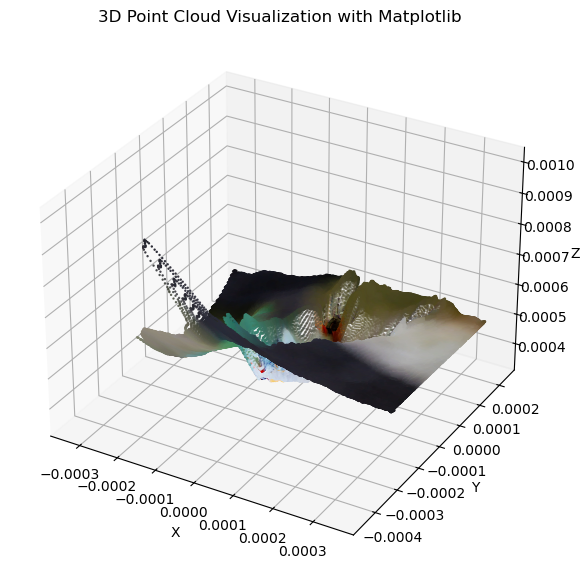

In [48]:
# Visualize in 3D

points = np.asarray(pcd_raw.points)
colors = np.asarray(pcd_raw.colors)

figure = plt.figure(figsize=(10, 7))
a = figure.add_subplot(111, projection='3d')
a.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=0.5)
a.set_xlabel('X')
a.set_ylabel('Y')
a.set_zlabel('Z')
plt.title('3D Point Cloud Visualization with Matplotlib')
plt.show()

In [53]:
pcd_raw.estimate_normals()
pcd_raw.orient_normals_to_align_with_direction()

In [14]:
o3d.visualization.draw_geometries([pcd])

In [51]:
# Mesh Reconstruction

mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_raw,depth=10,n_threads=1)[0]

rotation = mesh.get_rotation_matrix_from_xyz((np.pi,0,0))
mesh.rotate(rotation, center = (0, 0, 0))

o3d.visualization.draw_geometries([mesh],mesh_show_back_face=True)

In [52]:
# Save as .OBJ File

o3d.io.write_triangle_mesh('C:/Users/Admin/Pictures/result_2.obj',mesh)

True